In [123]:
from hough import imshow,bin_im2,plot_lines
from lines_generator import expand,norm
from skimage.transform import hough_line
import numpy as np
import cv2
import keras
from keras.models import load_model

In [2]:
model = load_model('models/model1.h5')

In [90]:
def genPatches(im_path,delta_angle=3000,patche_size=17):
    
    #load image
    im_gray = cv2.imread(im_path,cv2.IMREAD_GRAYSCALE)
    im_bin = bin_im2(im_gray)
    
    #hough transform
    im_h, theta, d = hough_line(im_bin,np.arange(-np.pi/2,np.pi/2,np.pi/delta_angle))
    im_h = im_h.astype('uint16')
    
    #Expand to convolution
    im_h = expand(np.array([im_h]),patche_size)[0]
    
    #sizes
    p = int((patche_size-1)/2)
    size = np.array(im_h.shape)-2*p
    
    #first time return size
    yield im_gray,im_bin,im_h
    
    #cut patches
    while(1):
        for y in range(size[0]):
            patches = list()
            for x in range(size[1]): 
                
                #cut
                patche = im_h[y:y+2*p+1,x:x+2*p+1]

                #matrix to vector
                patche = np.reshape(patche,patche_size**2)
                patches.append(patche)
                
            yield np.array(patches)


In [91]:
def reconstruct(label, size):
    im = np.reshape(label,size)
    return im

In [119]:
def mask2lines(mask,size_im):
    
    #mask to list of pixels
    size = mask.shape
    grid = np.mgrid[0:size[0],0:size[1]]
    xs = grid[1][mask]
    ys = grid[0][mask]

    #pixel to angle and distance
    dist_max = np.sqrt(size_im[0]**2+size_im[1]**2)
    angles = xs*np.pi/(size[1]-1) - np.pi/2
    dists = ys*(2*dist_max)/(size[0]-1) - dist_max
    
    return dists,angles

In [103]:
patche_size=17

name = 'imgs/lines.png'
gen = genPatches(name)
im_gray,im_bin,im_h = next(gen)

size_h = np.array(im_h.shape)
size_gray = np.array(im_gray.shape)

## Predict

In [11]:
%%time
for i in range(n_patches[0]):
    next(gen)

CPU times: user 35.3 s, sys: 340 ms, total: 35.6 s
Wall time: 35.6 s


In [19]:
%%time
pred = model.predict_generator(gen,steps = size_h[0]-17+1,verbose=1)
pred = pred[:,0]

2926/2926 [==============================] - 456s 156ms/step
CPU times: user 25min 25s, sys: 45.7 s, total: 26min 11s
Wall time: 7min 36s


## Plot

In [129]:
im = reconstruct(pred,size_h-patche_size+1)
mask = im>0.99

In [130]:
%%time
dists,angles = mask2lines(im>0.99,size_gray)

CPU times: user 103 ms, sys: 88.3 ms, total: 191 ms
Wall time: 190 ms


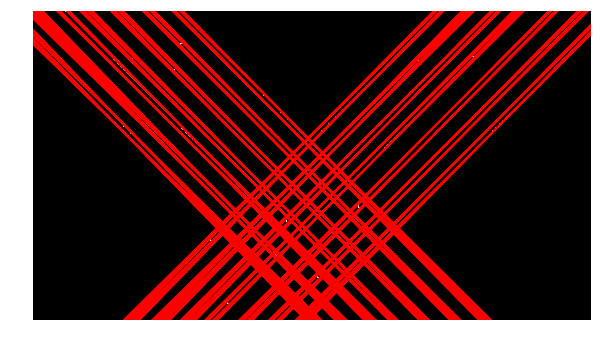

In [133]:
plot_lines(im_bin,dists,np.pi/2-angles) 